<a href="https://colab.research.google.com/github/avi13s/Data-Analysis-Presentation-Lab-HW2/blob/main/094295_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis & Presentation course - HW2 
## submission by : Avi 312485816 | Maxim 318828761
## Git : https://github.com/avi13s/Data-Analysis-Presentation-Lab-HW2

# Boiler Plate and file download

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
downloaded1 = drive.CreateFile({'id':"1GsC6vtBm47kNUPrCU-8_hXU1Pi0BraE9"})
downloaded1.GetContentFile('train.tar')
downloaded2 = drive.CreateFile({'id':"1JVCAqZOhKCs3_5KrlZakB-ZJZTcyZSS3"})
downloaded2.GetContentFile('test.tar')

In [ ]:
!tar -xf "train.tar" 
!tar -xf "test.tar"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # EDA
 ## below are 10 sample images with boxes on them (green box for class='True', red for class='False')

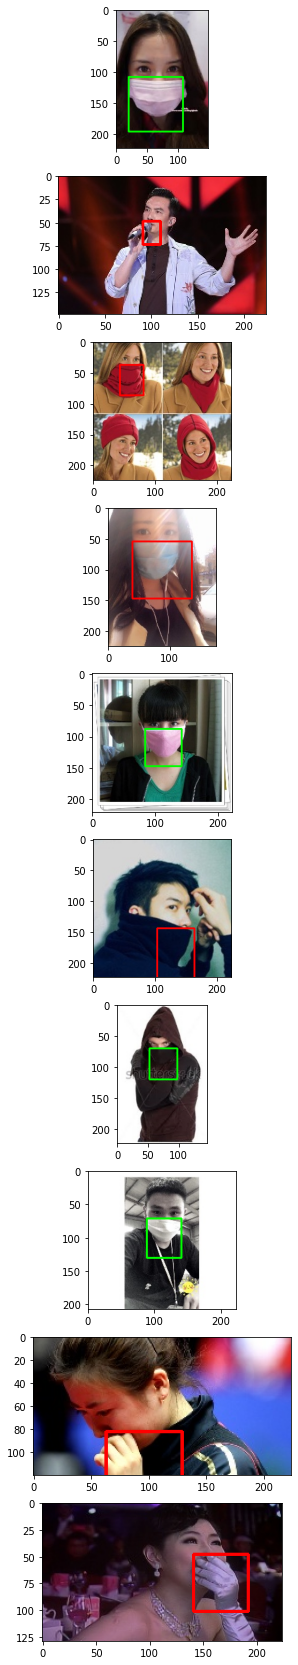

In [ ]:
import os
from PIL import Image

num_pics = 5
i_true = 0
i_false = 0

f, axarr = plt.subplots(10,1,figsize=(30, 30))
index = 0

for filename in os.listdir('/content/train/'):
  if i_true>=num_pics and i_false>=num_pics:
    break
  if filename.endswith(".asm") or filename.endswith(".py"): 
         # print(os.path.join(directory, filename))
    continue
  else:
    if filename[-8:-4] == 'True' and i_true<num_pics:
      i_true += 1
      _color = (0,255,0)
    else:
      i_false+=1
      _color = (0,0,255)
    curr_image = Image.open('/content/train/'+filename)
    width, height = curr_image.size
    split_name = filename.split(',')
    xmin = np.int(split_name[0].split('[')[1])
    xmax = xmin + np.int(split_name[2])
    ymax = np.int(split_name[1])
    ymin = ymax + np.int(split_name[3].split(']')[0])
    label = split_name[3].split('__')[1][:-4]


    img0 = cv2.imread('/content/train/'+filename)
    cv2.rectangle(img0, (xmin, ymin), (xmax, ymax), color=_color, thickness=2)
    img0 = cv2.cvtColor(img0, cv2.COLOR_RGB2BGR)
    if index<10:
      axarr[index].imshow(img0)
      index+= 1


Key takes from the pictures(and labels) seen above:

labels:
* The labels were probably generated by an ML model and not a human (as our definiton of "False" in the labels is pretty much what is hard for an ML model to classify but super-easy for a human)
* As our definitions of the labels are easier for a machine - we'll receive a model with lower real-world performance than what we'll measure here
* Very sensitive to noises (like a little sun even when mask is proper)

boxes:
* Tend to go lower than what we would expect (even more when there's no proper mask)
* Are much more accuracte when the person actually wears a good mask




Also :
* we printed out the counts of the classes in both training and test sets and we can see that thery're pretty balanced.

In [ ]:
train_df['label'].value_counts()

False    8596
True     7399
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

False    2150
True     1848
Name: label, dtype: int64

# Preprocessing
## Here we create a class for the dataset in order to later use torch's DataLoader module. We also make an auxilary df of the shape file_name,x1,x2,y1,y2,label for the dataset class and to ease our lives later on.

In [ ]:
# Making a df with file_name,x1,x2,y1,y2,label (This will be helpful later on)

import os
import pandas as pd
from PIL import Image

def check_validity(xmin,xmax,ymin,ymax):
  if xmin == xmax == ymin == ymax:
    return False
  if np.min([xmin, xmax, ymin, ymax, ymax-ymin, xmax-xmin])<=0:
    return False
  return True


def path_to_annot_df(path):
  annotation_dict = {}
  idx = 0
  for filename in os.listdir(path):
    split_name = filename.split(',')
    xmin = np.int(split_name[0].split('[')[1])
    xmax = xmin + np.int(split_name[2])
    ymin = np.int(split_name[1])
    ymax = ymin + np.int(split_name[3].split(']')[0])
    label = split_name[3].split('__')[1][:-4]
    if check_validity(xmin,xmax,ymin,ymax):
      annotation_dict[str(idx)] = [filename,xmin,xmax,ymin,ymax,label]
      idx += 1

  df = pd.DataFrame.from_dict(annotation_dict, orient='index',
                       columns=['file_name','x1', 'x2', 'y1', 'y2','label'])
  return df

In [ ]:
train_df = path_to_annot_df('/content/train/')
test_df = path_to_annot_df('/content/test/')

In [ ]:
train_df.head()

,file_name,x1,x2,y1,y2,label
0,"013970__[66, 67, 66, 67]__False.jpg",66,132,67,134,False
1,"003141__[92, 136, 108, 118]__False.jpg",92,200,136,254,False
2,"003576__[80, 83, 72, 72]__False.jpg",80,152,83,155,False
3,"001346__[63, 47, 41, 41]__True.jpg",63,104,47,88,True
4,"009148__[82, 42, 49, 59]__True.jpg",82,131,42,101,True


In [ ]:
import os
import cv2
import time
import numpy as np

from PIL import Image

import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
### Creating Data (Labels & Targets) for Faster R-CNN

class FaceMaskDetectionDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode = 'train', transforms = None):
        
        super().__init__()
        
        self.image_names = dataframe["file_name"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index: int):
        
        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df["file_name"] == image_name]
        
        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.mode == 'train':
            
            #Get bounding box co-ordinates for each box
            boxes = records[['x1', 'y1', 'x2', 'y2']].values

            #Getting labels for each box
            labels = [int(records['label'][0] == 'True')]

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name
        
        elif self.mode == 'test':

            if self.transforms:
                image = self.transforms(image)

            return image, image_name
    
    def __len__(self):
        return len(self.image_names)

In [ ]:
def get_transform():
    return T.Compose([T.ToTensor()])

In [ ]:
DIR_Train = '/content/train/'
DIR_Test = '/content/test/'

# Experiment 1
### As the first experiment, we mostly try to familiarize ourselves with a popular model and use standard hyperparameters
* Architecture: Faster RCNN ( Using resnet50  (not pretrained of course!) for feature extraction):

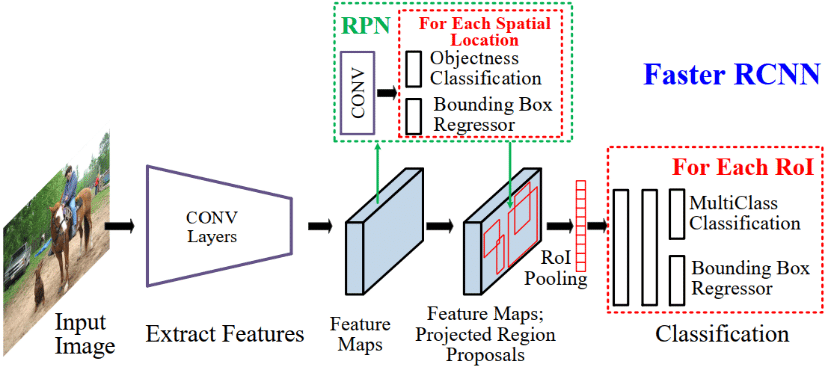

* Loss functions, hyperparameters, regularization. : Defaults given by the FasterRCNN model in torchvision.models

* Optimizer: also kind of a default - SGD(params, lr = 0.005, momentum = 0.9)

* Epochs: 5 

* Time per epoch: around 50mins on colab notebooks

* No hyper-parameter tuning so far as this experiment should give us a (well performing) baseline

* **Interesting/important note**: not on all data points we have recevied an outpout from the model - therefore based on the EDA before (and seeing locations of boxes and class distributions) we gave default values of "False" as class to images that weren't classified by the model, and drew boxes in the middle of the image (x,y,w,h = 0.4 x pic_width,0.4 x pic_height,0.2 x pic_width,0.2 x pic_height)

* Experiment mostly based on https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html, and using dataset adjustement ideas from:
 https://www.kaggle.com/jainamshah17/face-mask-detection-using-faster-r-cnn-pytorch



# Experiment 1 - code

In [ ]:
### Preparing data for Train

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = FaceMaskDetectionDataset(train_df, DIR_Train, transforms = get_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

#Faster - RCNN Model - not pretrained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
### Preparing model for training

#Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]

#Defininig Optimizer
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9)

model.to(device)

epochs = 5

In [ ]:
itr = 1
total_train_loss = []

train_output = {}
test_output = {}

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss = []
    
    #Retriving Mini-batch
    for images, targets, image_names in train_data_loader:

        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        #Forward propagation
        out = model(images, targets)
        losses = sum([loss for loss in out.values()])
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        #Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        

        if itr % 500 == 0:
            print(f"\n Iteration #{itr} loss: {out} \n")

            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"/content/drive/MyDrive/checkpoint_{epoch}_{itr}.pth")
                
        itr += 1
    
    #lr_scheduler.step()    
    
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)


 Iteration #500 loss: {'loss_classifier': tensor(0.0591, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0673, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0095, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #1000 loss: {'loss_classifier': tensor(0.0334, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0584, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #1500 loss: {'loss_classifier': tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0340, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_bo

# Running inference and graphing

In [ ]:
# Performance of the model(after completing 5 epochs) on the test set: (average IoU & Accuracy)
calc_avg_iou_acc(test_df, df)

(0.5518643801552443, 0.7888944472236118)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

#Test Dataset
test_dataset = FaceMaskDetectionDataset(test_df, DIR_Test, mode = 'train', transforms = get_transform())

#Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

train_dataset = FaceMaskDetectionDataset(train_df, DIR_Train, mode = 'train', transforms = get_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [ ]:
def calc_IoU(box1, box2):

  eps = 1e-10 #random noise

	#Making an intersection box
  x1_inter = max(box1[0], box2[0])
  y1_inter = max(box1[1], box2[1])
  x2_inter = min(box1[2], box2[2])
  y2_inter = min(box1[3], box2[3])

  #Calculating rectangle areas:
  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
  inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

  IoU = inter_area / np.float(box1_area + box2_area - inter_area + eps)
  # return the intersection over union value
  return IoU

In [ ]:
itr = 500
epoch = 0

train_loss = []
train_iou = []
train_acc = []

test_loss = []
test_iou = []
test_acc = []



while itr<= 19500:
  if itr in [5000, 8000, 12500, 17000]:
    epoch += 1

  checkpoint = torch.load(f"/content/drive/MyDrive/checkpoint_{epoch}_{itr}.pth")
  model.load_state_dict(checkpoint['model_state_dict'])

  idx = 0

  import time
  st_dt = time.time()

  tot_train_loss = 0
  tot_train_iou = 0
  tot_train_acc = 0

  with torch.no_grad():
    for images, targets, image_names in train_data_loader:
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model.train()

        #Forward propagation to get current loss
        loss_values = model(images, targets)
        tot_train_loss += sum([loss for loss in loss_values.values()])
        
        model.eval()
        output = model(images)
        #Converting tensors to array
        boxes = output[0]['boxes'].data.cpu().numpy()
        scores = output[0]['scores'].data.cpu().numpy()

        # If no box found - we'll give a default prediction of False and a box in the middle
        if len(boxes)<1:
          x1 = 0.4*images[0].size()[1]
          x2 = 0.6*images[0].size()[1]
          y1 = 0.4*images[0].size()[2]
          y2 = 0.6*images[0].size()[2]
          prediction = 0
        else:
          x1 = boxes[0][0]
          y1 = boxes[0][1]
          x2 = boxes[0][2]
          y2 = boxes[0][3]
          prediction = 1 if scores[0]>0.5 else 0
        tot_train_iou += calc_IoU([x1,y1,x2,y2],targets[0]['boxes'][0])
        tot_train_acc += int(targets[0]['labels'][0] == prediction)
        idx += 1
        if idx%2000 == 0:
          print(f"model of itr {itr} finished {idx} items, in {time.time()-st_dt} seconds \n results are {tot_train_loss / idx, tot_train_iou / idx, tot_train_acc / idx}")
          break

  train_loss.append(float(tot_train_loss) / idx)
  train_iou.append(float(tot_train_iou) / idx)
  train_acc.append(tot_train_acc / idx)

  idx = 0
  st_dt = time.time()

  tot_test_loss = 0
  tot_test_iou = 0
  tot_test_acc = 0

  with torch.no_grad():
    for images, targets, image_names in test_data_loader:
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model.train()

        #Forward propagation to get current loss
        loss_values = model(images, targets)
        tot_test_loss += sum([loss for loss in loss_values.values()])
        
        model.eval()
        output = model(images)
        #Converting tensors to array
        boxes = output[0]['boxes'].data.cpu().numpy()
        scores = output[0]['scores'].data.cpu().numpy()

        # If no box found - we'll give a default prediction of False and a box in the middle
        if len(boxes)<1:
          x1 = 0.4*images[0].size()[1]
          x2 = 0.6*images[0].size()[1]
          y1 = 0.4*images[0].size()[2]
          y2 = 0.6*images[0].size()[2]
          prediction = 0
        else:
          x1 = boxes[0][0]
          y1 = boxes[0][1]
          x2 = boxes[0][2]
          y2 = boxes[0][3]
          prediction = 1 if scores[0]>0.5 else 0
        tot_test_iou += calc_IoU([x1,y1,x2,y2],targets[0]['boxes'][0])
        tot_test_acc += int(targets[0]['labels'][0] == prediction)
        idx += 1
        if idx%2000 == 0:
          print(f"model of itr {itr} finished {idx} items, in {time.time()-st_dt} seconds \n results are {tot_test_loss / idx, tot_test_iou / idx, tot_test_acc / idx}")
          break
  test_loss.append(float(tot_test_loss) / idx)
  test_iou.append(float(tot_test_iou) / idx)
  test_acc.append(tot_test_acc / idx)
  if itr<18000:
    itr += 1500 
  else:
    itr += 1000

model of itr 500 finished 2000 items, in 304.45991587638855 seconds 
 results are (tensor(0.0836, device='cuda:0'), tensor(0.5177, device='cuda:0'), 0.6795)
model of itr 500 finished 2000 items, in 303.72232961654663 seconds 
 results are (tensor(0.0863, device='cuda:0'), tensor(0.5200, device='cuda:0'), 0.712)
model of itr 2000 finished 2000 items, in 303.77816438674927 seconds 
 results are (tensor(0.0815, device='cuda:0'), tensor(0.5146, device='cuda:0'), 0.7695)
model of itr 2000 finished 2000 items, in 303.89013266563416 seconds 
 results are (tensor(0.0805, device='cuda:0'), tensor(0.5126, device='cuda:0'), 0.7715)
model of itr 3500 finished 2000 items, in 304.73656845092773 seconds 
 results are (tensor(0.0754, device='cuda:0'), tensor(0.5353, device='cuda:0'), 0.8)
model of itr 3500 finished 2000 items, in 303.83609199523926 seconds 
 results are (tensor(0.0780, device='cuda:0'), tensor(0.5174, device='cuda:0'), 0.7965)
model of itr 5000 finished 2000 items, in 306.197851657867

# Experiment 1 graphs
## Graphing method and notes:
* Method : 

  1) We saved pickles of the model during the training (every ~8K data points), as we think it's good practice if storage space is available

  2) We ran each pickled model on a random sample of 2000 data points of training & 2000 points of test (as we think it's a waste of resources and time to run on full datasets just for graphing, and 2000 data points seem like enough to not stray to much from the ground truth)

  3) We used torch.no_grad() while graphing and also model.train() for loss value and then model.eval() to retrieve boxes and classifications

* Unfortunately X-axis isn't the most clear and running again to edit would take too long. But - basically at x=0 we have the model that trained on 2K data points and then we increment around 6K data points until the last model is the one that finished 5 epochs. Basically 0.25->5 epochs



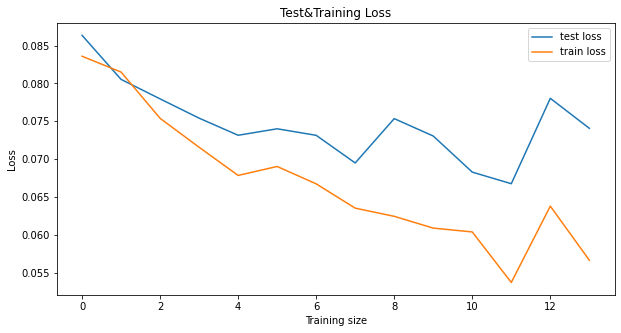

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Test&Training Loss")
plt.plot(test_loss,label="test loss")
plt.plot(train_loss,label="train loss")
plt.xlabel("Training size")
plt.ylabel("Loss")
plt.legend()
plt.show()

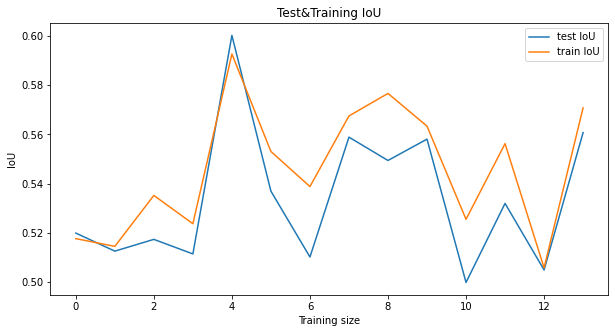

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Test&Training IoU")
plt.plot(test_iou,label="test IoU")
plt.plot(train_iou,label="train IoU")
plt.xlabel("Training size")
plt.ylabel("IoU")
plt.legend()
plt.show()

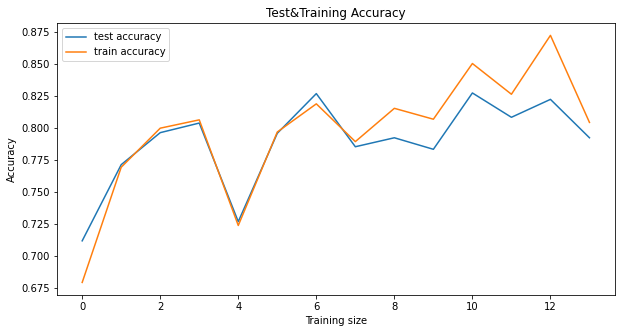

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Test&Training Accuracy")
plt.plot(test_acc,label="test accuracy")
plt.plot(train_acc,label="train accuracy")
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Observations from experiment 1:
* 5 epochs don't seem to be enought in these settings 
* Clearly there's a trade-off between IoU and accuracy here - means we may need to split into two models depending on test performance for each evaluation metric
* Learning curve seems to be erroneous - we may need to lower the LR

 # Experiment 2
 ### We can see from graphs above that the performance isn't very consistent over the training time.
### This indicates we may need to lower the Learning rate and perform more epochs. 
### So in this experiment we:
* Lowered the initial LR and performed more epochs
* Changed the optimizer to Adam
* Used an LR scheduler to adjust LR 
* Performed more epochs (12 in comparison with 5 in experiment 1)
* Hoped for the best

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

#Faster - RCNN Model - not pretrained
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2

# get number of input features for the classifier
in_features = model2.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
### Preparing model for training

#Retriving all trainable parameters from model (for optimizer)
params = [p for p in model2.parameters() if p.requires_grad]

#Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)

#optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9)

#LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# If have pretrained (own pretrained)
"""
checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pth')
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
"""
model2.to(device)

#No of epochs
epochs = 12

In [ ]:
itr = 1
total_train_loss = []

train_output = {}
test_output = {}

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss = []
    
    #Retriving Mini-batch
    for images, targets, image_names in train_data_loader:

        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        #Forward propagation
        out = model2(images, targets)
        losses = sum([loss for loss in out.values()])
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1)
        optimizer.step()
        
        #Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        

        if itr % 2000 == 0:
            print(f"\n Iteration #{itr} loss: {out} \n")

            torch.save({
            'epoch': epoch,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"/content/drive/MyDrive/checkpoint_model2_{itr}.pth")
                
        itr += 1
    
    lr_scheduler.step()
    
    epoch_train_loss = np.mean(train_loss)
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



 Iteration #2000 loss: {'loss_classifier': tensor(0.0701, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)} 

Epoch train loss is 0.0893
Time elapsed:  3068.1817026138306

 Iteration #4000 loss: {'loss_classifier': tensor(0.0200, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0340, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0066, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)} 


 Iteration #6000 loss: {'loss_classifier': tensor(0.0334, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0545, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0036, device='cuda:0',

In [ ]:
torch.save({
'epoch': epoch,
'model_state_dict': model2.state_dict(),
'optimizer_state_dict': optimizer.state_dict()
}, f"/content/drive/MyDrive/checkpoint_model2_{itr}.pth")

# Experiment 2 - graphing

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

#Test Dataset
test_dataset = FaceMaskDetectionDataset(test_df, DIR_Test, mode = 'train', transforms = get_transform())

#Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

train_dataset = FaceMaskDetectionDataset(train_df, DIR_Train, mode = 'train', transforms = get_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [ ]:
def calc_IoU(box1, box2):

  eps = 1e-10 #random noise

	#Making an intersection box
  x1_inter = max(box1[0], box2[0])
  y1_inter = max(box1[1], box2[1])
  x2_inter = min(box1[2], box2[2])
  y2_inter = min(box1[3], box2[3])

  #Calculating rectangle areas:
  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
  inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

  IoU = inter_area / np.float(box1_area + box2_area - inter_area + eps)
  # return the intersection over union value
  return IoU

In [ ]:
itr = 4000
epoch = 0

train_loss = []
train_iou = []
train_acc = []

test_loss = []
test_iou = []
test_acc = []



while itr<= 48000:
  checkpoint = torch.load(f"/content/drive/MyDrive/checkpoint_model2_{itr}.pth")
  model_2.load_state_dict(checkpoint['model_state_dict'])

  idx = 0

  import time
  st_dt = time.time()

  tot_train_loss = 0
  tot_train_iou = 0
  tot_train_acc = 0

  with torch.no_grad():
    for images, targets, image_names in train_data_loader:
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model_2.train()

        #Forward propagation to get current loss
        loss_values = model_2(images, targets)
        tot_train_loss += sum([loss for loss in loss_values.values()])
        
        model_2.eval()
        output = model_2(images)
        #Converting tensors to array
        boxes = output[0]['boxes'].data.cpu().numpy()
        scores = output[0]['scores'].data.cpu().numpy()

        # If no box found - we'll give a default prediction of False and a box in the middle
        if len(boxes)<1:
          x1 = 0.4*images[0].size()[1]
          x2 = 0.6*images[0].size()[1]
          y1 = 0.4*images[0].size()[2]
          y2 = 0.6*images[0].size()[2]
          prediction = 0
        else:
          x1 = boxes[0][0]
          y1 = boxes[0][1]
          x2 = boxes[0][2]
          y2 = boxes[0][3]
          prediction = 1 if scores[0]>0.5 else 0
        tot_train_iou += calc_IoU([x1,y1,x2,y2],targets[0]['boxes'][0])
        tot_train_acc += int(targets[0]['labels'][0] == prediction)
        idx += 1
        if idx%2000 == 0:
          print(f"model of itr {itr} finished {idx} items, in {time.time()-st_dt} seconds \n results are {tot_train_loss / idx, tot_train_iou / idx, tot_train_acc / idx}")
          break

  train_loss.append(float(tot_train_loss) / idx)
  train_iou.append(float(tot_train_iou) / idx)
  train_acc.append(tot_train_acc / idx)

  idx = 0
  st_dt = time.time()

  tot_test_loss = 0
  tot_test_iou = 0
  tot_test_acc = 0

  with torch.no_grad():
    for images, targets, image_names in test_data_loader:
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model_2.train()

        #Forward propagation to get current loss
        loss_values = model_2(images, targets)
        tot_test_loss += sum([loss for loss in loss_values.values()])
        
        model_2.eval()
        output = model_2(images)
        #Converting tensors to array
        boxes = output[0]['boxes'].data.cpu().numpy()
        scores = output[0]['scores'].data.cpu().numpy()

        # If no box found - we'll give a default prediction of False and a box in the middle
        if len(boxes)<1:
          x1 = 0.4*images[0].size()[1]
          x2 = 0.6*images[0].size()[1]
          y1 = 0.4*images[0].size()[2]
          y2 = 0.6*images[0].size()[2]
          prediction = 0
        else:
          x1 = boxes[0][0]
          y1 = boxes[0][1]
          x2 = boxes[0][2]
          y2 = boxes[0][3]
          prediction = 1 if scores[0]>0.5 else 0
        tot_test_iou += calc_IoU([x1,y1,x2,y2],targets[0]['boxes'][0])
        tot_test_acc += int(targets[0]['labels'][0] == prediction)
        idx += 1
        if idx%2000 == 0:
          print(f"model of itr {itr} finished {idx} items, in {time.time()-st_dt} seconds \n results are {tot_test_loss / idx, tot_test_iou / idx, tot_test_acc / idx}")
          break
  test_loss.append(float(tot_test_loss) / idx)
  test_iou.append(float(tot_test_iou) / idx)
  test_acc.append(tot_test_acc / idx)
  itr+=4000

model of itr 4000 finished 2000 items, in 284.64907693862915 seconds 
 results are (tensor(0.0766, device='cuda:0'), tensor(0.5844, device='cuda:0'), 0.757)
model of itr 4000 finished 2000 items, in 284.0388205051422 seconds 
 results are (tensor(0.0778, device='cuda:0'), tensor(0.5691, device='cuda:0'), 0.7515)
model of itr 8000 finished 2000 items, in 285.78625226020813 seconds 
 results are (tensor(0.0752, device='cuda:0'), tensor(0.6187, device='cuda:0'), 0.6955)
model of itr 8000 finished 2000 items, in 284.76741218566895 seconds 
 results are (tensor(0.0805, device='cuda:0'), tensor(0.6032, device='cuda:0'), 0.6955)
model of itr 12000 finished 2000 items, in 285.1158423423767 seconds 
 results are (tensor(0.0536, device='cuda:0'), tensor(0.6034, device='cuda:0'), 0.7985)
model of itr 12000 finished 2000 items, in 283.916232585907 seconds 
 results are (tensor(0.0637, device='cuda:0'), tensor(0.6026, device='cuda:0'), 0.7755)
model of itr 16000 finished 2000 items, in 284.92859053

# Experiment 2 - Graphs
#### only note here is that on the graphs' x epochs are counted "computer-science-style" (from 0 to 11 instead of 1 to 12)

In [ ]:
# (IoU,Accuracy) of the second model after finishing 12 epochs
calc_avg_iou_acc(test_df, submission)

(0.5529648423821962, 0.8094047023511756)

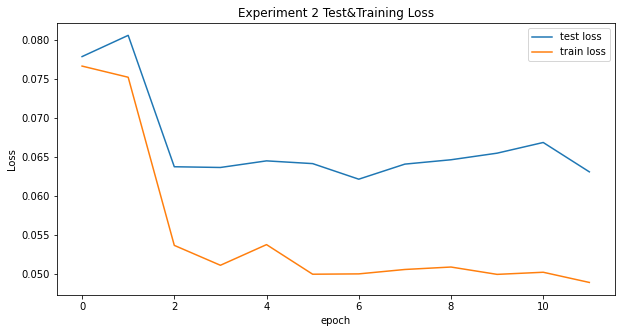

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Experiment 2 Test&Training Loss")
plt.plot(test_loss,label="test loss")
plt.plot(train_loss,label="train loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

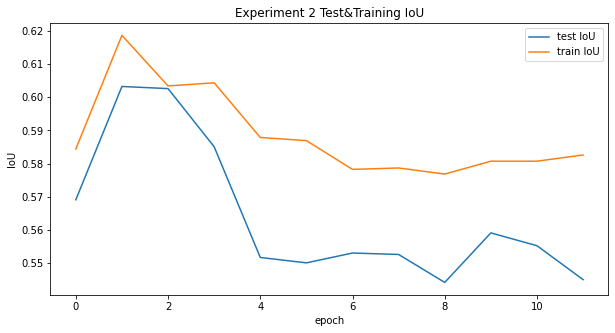

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Experiment 2 Test&Training IoU")
plt.plot(test_iou,label="test IoU")
plt.plot(train_iou,label="train IoU")
plt.xlabel("epoch")
plt.ylabel("IoU")
plt.legend()
plt.show()

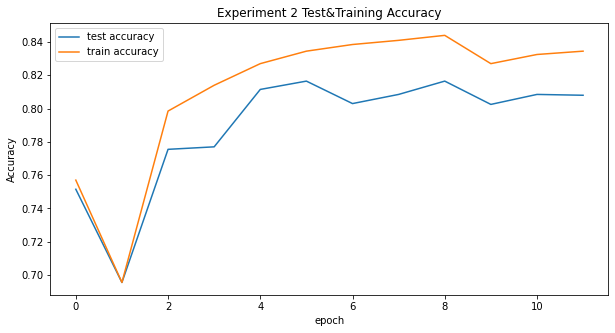

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Experiment 2 Test&Training Accuracy")
plt.plot(test_acc,label="test accuracy")
plt.plot(train_acc,label="train accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## observations from the graphs:
* Indeed our graphs look more stable than in experiment 1 (makes sense as we doubled the epochs)
* We can still see some trade off between IoU & accuracy
* It seems like we stopped improving on test around the middle (~epoch 6)
* We did not improve much on experiment 1 (mostly have better IoU scores, but Accuracy is the same or a bit lower)

# Conclusions
* Not surprising but: object detection is very heavy computationally
* IoU is not a very "forgiving" metric
* As said before - there's a trade off between accuracy on object detection and IoU. Which for us is a bit surprising as you would expect that a model such as this (pretty popular and an improvement over older ones) would have dealt with such a thing, **without us having to use two checkpoints**** of the models to get the best of the two worlds

** At the end, for the submission file we will need to load models from two checkpoints, one that performs best IoU-wise on test data and the is the most accurate that we've encountered during making the graphs.

# **Final performance on test data: ~60% IoU, ~82.5% Accuracy with hybrid model**

# Misc. - creating scripts for predict.py, validations, evaluations, etc. (pretty ugly and un-organized there)

In [ ]:
DIR_IoU_model = '/content/drive/MyDrive/checkpoint_model2_12000.pth'
DIR_acc_model = '/content/drive/MyDrive/checkpoint_3_15500.pth'

In [ ]:
submission = pd.DataFrame(columns = ["filename", "x", "y", "w", "h", "proper_mask"])

In [ ]:
#Faster - RCNN Model - not pretrained
model_acc = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model_Iou = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# get number of input features for the classifier
in_features = model_acc.roi_heads.box_predictor.cls_score.in_features
in_features = model_Iou.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
num_classes = 2
model_Iou.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_acc.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

checkpoint_iou = torch.load('DIR_IoU_model)
model_Iou.load_state_dict(checkpoint_iou['model_state_dict'])


checkpoint_acc = torch.load(DIR_acc_model)
model_acc.load_state_dict(checkpoint_acc['model_state_dict'])

model_Iou.to(device)
model_acc.to(device)

In [ ]:
import time

model_acc.eval()
model_Iou.eval()


start_time= time.time()

for images, targets, image_names in test_data_loader:
    #Forward ->
    images = list(image.to(device) for image in images)
    output_Iou = model_Iou(images, targets)
    output_acc = model_acc(images, targets)
    #Converting tensors to array
    boxes = output_Iou[0]['boxes'].data.cpu().numpy()
    scores = output_acc[0]['scores'].data.cpu().numpy()


    # If no box found - we'll give a default prediction of False and a box in the middle

    if len(boxes)<1:

      x1 = 0.4*images[0].size()[1]
      y1 = 0.4*images[0].size()[2]
      x2 = 0.6*images[0].size()[1]
      y2 = 0.6*images[0].size()[2]
    else:
      x1 = boxes[0][0]
      y1 = boxes[0][1]
      x2 = boxes[0][2]
      y2 = boxes[0][3]

    if len(scores)<1:
      class_pred = 'False'
    else:
      class_pred = 'True' if scores[0]>0.5 else 'False'
    #Bboxes, classname & image name
        
    #Creating row for df
    row = {"filename" : image_names[0], "x" : x1, "y" : y1, "w" : x2-x1, "h" : y2-y1, "proper_mask" : class_pred}
    
    #Appending to df
    submission = submission.append(row, ignore_index = True)

print(f"inference on test took {(time.time() - start_time)/60} minutes ")

inference on test took 9.541640710830688 minutes 


In [ ]:
output

[{'boxes': tensor([[ 87.3850,  71.8225, 156.1127, 137.9287]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9340], device='cuda:0', grad_fn=<IndexBackward>)}]

In [ ]:
loss

NameError: ignored

In [ ]:
test_df

,file_name,x1,x2,y1,y2,label
0,"018668__[100, 96, 80, 89]__False.jpg",100,180,96,185,False
1,"017823__[61, 51, 53, 57]__True.jpg",61,114,51,108,True
2,"016340__[99, 72, 51, 53]__False.jpg",99,150,72,125,False
3,"016790__[89, 69, 49, 49]__False.jpg",89,138,69,118,False
4,"019253__[65, 107, 79, 84]__False.jpg",65,144,107,191,False
...,...,...,...,...,...,...
3993,"017809__[54, 81, 71, 68]__True.jpg",54,125,81,149,True
3994,"016488__[40, 79, 13, 16]__True.jpg",40,53,79,95,True
3995,"017407__[99, 102, 63, 82]__False.jpg",99,162,102,184,False
3996,"016178__[70, 85, 26, 47]__True.jpg",70,96,85,132,True


In [ ]:
def calc_IoU(box1, sub):

  eps = 1e-10 #random noise

	#Making an intersection box
  x1_inter = max(box1[0], sub[0])
  x2_inter = min(box1[1], sub[0]+sub[2])
  y1_inter = max(box1[2], sub[1])
  y2_inter = min(box1[3], sub[1]+sub[3])

  #Calculating rectangle areas:
  box1_area = (box1[1] - box1[0]) * (box1[3] - box1[2])
  box2_area = (sub[2]) * (sub[3])
  inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

  IoU = inter_area / np.float(box1_area + box2_area - inter_area)
  # return the intersection over union value
  return IoU

In [ ]:
def calc_avg_iou_acc(df1,df2):
  total_iou = 0
  total_acc = 0
  num_rows = len(df1)
  for idx in range(num_rows):
    curr_df2 = df2[df2['filename'] == df1.iloc[idx][0]]
    df2_idx = int(curr_df2.loc[:]['x'].index[0])
    total_iou += calc_IoU(df1.iloc[idx][1:5], [curr_df2.loc[df2_idx]['x'],curr_df2.loc[df2_idx]['y'],curr_df2.loc[df2_idx]['w'],curr_df2.loc[df2_idx]['h']])
    total_acc += int(df1.iloc[idx][5] == str(curr_df2.loc[df2_idx]['proper_mask']))
  return total_iou/num_rows, total_acc/num_rows

In [ ]:
calc_avg_iou_acc(test_df,submission)

(0.595872058685288, 0.8251625812906453)

In [ ]:
import pandas as pd

df = pd.read_csv('/content/prediction (2).csv')

In [ ]:
submission

,filename,x,y,w,h,proper_mask
0,"018942__[42, 126, 166, 199]__False.jpg",23.205231,63.500843,171.928696,127.075500,False
1,"017390__[107, 64, 34, 43]__True.jpg",107.585495,60.107655,36.761673,42.311459,True
2,"017703__[81, 50, 21, 22]__True.jpg",78.701370,51.299343,33.878090,40.889324,True
3,"019381__[90, 79, 66, 69]__True.jpg",90.243858,85.025322,70.013298,77.332863,True
4,"016959__[48, 150, 141, 154]__True.jpg",29.283867,138.941238,164.762238,85.058762,False
...,...,...,...,...,...,...
3993,"017619__[83, 56, 42, 52]__False.jpg",80.558235,54.219032,46.095665,54.840012,False
3994,"018344__[19, 169, 67, 69]__False.jpg",22.096186,167.947449,57.204773,56.052551,False
3995,"016735__[158, 50, 28, 33]__True.jpg",157.013809,48.710476,23.951141,27.687412,True
3996,"017550__[75, 60, 39, 62]__True.jpg",76.519539,52.182240,43.102165,58.151760,True


In [ ]:
# Making a df with file_name,x1,x2,y1,y2,label (This will be helpful later on)

import os
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

In [ ]:
def check_validity(xmin,xmax,ymin,ymax):
  if xmin == xmax == ymin == ymax:
    return False
  if np.min([xmin, xmax, ymin, ymax, ymax-ymin, xmax-xmin])<=0:
    return False
  return True


def path_to_annot_df(path):
  annotation_dict = {}
  idx = 0
  for filename in os.listdir(path):
    split_name = filename.split(',')
    xmin = np.int(split_name[0].split('[')[1])
    xmax = xmin + np.int(split_name[2])
    ymin = np.int(split_name[1])
    ymax = ymin + np.int(split_name[3].split(']')[0])
    label = split_name[3].split('__')[1][:-4]
    if check_validity(xmin,xmax,ymin,ymax):
      annotation_dict[str(idx)] = [filename,xmin,xmax,ymin,ymax,label]
      idx += 1

  df = pd.DataFrame.from_dict(annotation_dict, orient='index',
                       columns=['file_name','x1', 'x2', 'y1', 'y2','label'])
  return df


def get_transform():
  return T.Compose([T.ToTensor()])

In [ ]:
class FaceMaskDetectionDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode = 'train', transforms = None):
        
        super().__init__()
        
        self.image_names = dataframe["file_name"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index: int):
        
        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df["file_name"] == image_name]
        
        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.mode == 'train':
            
            #Get bounding box co-ordinates for each box
            boxes = records[['x1', 'y1', 'x2', 'y2']].values

            #Getting labels for each box
            labels = [int(records['label'][0] == 'True')]

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name
        
        elif self.mode == 'test':

            if self.transforms:
                image = self.transforms(image)

            return image, image_name
    
    def __len__(self):
        return len(self.image_names)



In [ ]:
DIR_Test = '/content/test/'
DIR_pkl = '/content/drive/MyDrive/checkpoint_4_19500.pth'
test_df = path_to_annot_df(DIR_Test)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

#Test Dataset
test_dataset = FaceMaskDetectionDataset(test_df, DIR_Test, mode = 'train', transforms = get_transform())

#Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
#Loading cuda device and initializing the model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

#Faster - RCNN Model - not pretrained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
#Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]

#Defininig Optimizer

#optimizer = torch.optim.Adam(params, lr = 0.0001)
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9)

#LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# If have pretrained (own pretrained)
checkpoint = torch.load(DIR_pkl)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.to(device)
model.eval()

In [ ]:
submission = pd.DataFrame(columns = ["filename", "x", "y", "w", "h", "proper_mask"])

for images, image_names in test_data_loader:
    #Forward
    images = list(image.to(device) for image in images)
    output = model(images)
    
    #Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()

    # If no box found - we'll give a default prediction of False and a box in the middle
    if len(boxes)<1:
      row = {"filename" : image_names[0], "x" : 0.4*images[0].size()[1],  "y" : 0.4*images[0].size()[2], "w" : 0.2*images[0].size()[1], "h" : 0.2*images[0].size()[2], "proper_mask" : 'False'}
      submission = submission.append(row, ignore_index = True)
      continue
  
    #Bboxes, classname & image name
    x1 = boxes[0][0]
    y1 = boxes[0][1]
    x2 = boxes[0][2]
    y2 = boxes[0][3]
    prediction = 'True' if scores[0]>0.5 else 'False'
    
    #Creating row for df
    row = {"filename" : image_names[0], "x" : x1, "y" : y1, "w" : x2-x1, "h" : y2-y1, "proper_mask" : prediction}
    
    #Appending to df
    submission = submission.append(row, ignore_index = True)

In [ ]:
submission.to_csv('prediction.csv',index=False)

In [ ]:
import os
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

DIR_Test = '/content/test/'
DIR_pkl = '/content/drive/MyDrive/checkpoint_4_19500.pth'


def check_validity(xmin,xmax,ymin,ymax):
  if xmin == xmax == ymin == ymax:
    return False
  if np.min([xmin, xmax, ymin, ymax, ymax-ymin, xmax-xmin])<=0:
    return False
  return True


def path_to_annot_df(path):
  annotation_dict = {}
  idx = 0
  for filename in os.listdir(path):
    split_name = filename.split(',')
    xmin = np.int(split_name[0].split('[')[1])
    xmax = xmin + np.int(split_name[2])
    ymin = np.int(split_name[1])
    ymax = ymin + np.int(split_name[3].split(']')[0])
    label = split_name[3].split('__')[1][:-4]
    if check_validity(xmin,xmax,ymin,ymax):
      annotation_dict[str(idx)] = [filename,xmin,xmax,ymin,ymax,label]
      idx += 1

  df = pd.DataFrame.from_dict(annotation_dict, orient='index',
                       columns=['file_name','x1', 'x2', 'y1', 'y2','label'])
  return df


def get_transform():
  return T.Compose([T.ToTensor()])

class FaceMaskDetectionDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode = 'train', transforms = None):
        
        super().__init__()
        
        self.image_names = dataframe["file_name"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index: int):
        
        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df["file_name"] == image_name]
        
        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.mode == 'train':
            
            #Get bounding box co-ordinates for each box
            boxes = records[['x1', 'y1', 'x2', 'y2']].values

            #Getting labels for each box
            labels = [int(records['label'][0] == 'True')]

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name
        
        elif self.mode == 'test':

            if self.transforms:
                image = self.transforms(image)

            return image, image_name
    
    def __len__(self):
        return len(self.image_names)

test_df = path_to_annot_df(DIR_Test)

def collate_fn(batch):
    return tuple(zip(*batch))

#Test Dataset
test_dataset = FaceMaskDetectionDataset(test_df, DIR_Test, mode = 'test', transforms = get_transform())

#Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

#Loading cuda device and initializing the model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

#Faster - RCNN Model - not pretrained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]

#Defininig Optimizer

#optimizer = torch.optim.Adam(params, lr = 0.0001)
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9)

#LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# If have pretrained (own pretrained)
checkpoint = torch.load(DIR_pkl)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.to(device)
model.eval()

submission = pd.DataFrame(columns = ["filename", "x", "y", "w", "h", "proper_mask"])

for images, image_names in test_data_loader:
    #Forward
    images = list(image.to(device) for image in images)
    output = model(images)
    
    #Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()

    # If no box found - we'll give a default prediction of False and a box in the middle
    if len(boxes)<1:
      row = {"filename" : image_names[0], "x" : 0.4*images[0].size()[1],  "y" : 0.4*images[0].size()[2], "w" : 0.2*images[0].size()[1], "h" : 0.2*images[0].size()[2], "proper_mask" : 'False'}
      submission = submission.append(row, ignore_index = True)
      continue
  
    #Bboxes, classname & image name
    x1 = boxes[0][0]
    y1 = boxes[0][1]
    x2 = boxes[0][2]
    y2 = boxes[0][3]
    prediction = 'True' if scores[0]>0.5 else 'False'
    
    #Creating row for df
    row = {"filename" : image_names[0], "x" : x1, "y" : y1, "w" : x2-x1, "h" : y2-y1, "proper_mask" : prediction}
    
    #Appending to df
    submission = submission.append(row, ignore_index = True)

submission.to_csv('prediction_2.csv',index=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def calc_IoU(box1, sub):

  eps = 1e-10 #random noise

	#Making an intersection box
  x1_inter = max(box1[0], sub[0])
  x2_inter = min(box1[1], sub[0]+sub[2])
  y1_inter = max(box1[2], sub[1])
  y2_inter = min(box1[3], sub[1]+sub[3])

  #Calculating rectangle areas:
  box1_area = (box1[1] - box1[0]) * (box1[3] - box1[2])
  box2_area = (sub[2]) * (sub[3])
  inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

  IoU = inter_area / np.float(box1_area + box2_area - inter_area)
  # return the intersection over union value
  return IoU

In [ ]:
def calc_avg_iou_acc(df1,df2):
  total_iou = 0
  total_acc = 0
  num_rows = len(df1)
  for idx in range(num_rows):
    total_iou += calc_IoU(df1.iloc[idx][1:5],df2.iloc[idx][1:5])
    total_acc += int(df1.iloc[idx][5] == df2.iloc[idx][5])
  return total_iou/num_rows, total_acc/num_rows

In [ ]:
submission

,filename,x,y,w,h,proper_mask
0,"017093__[69, 29, 29, 35]__True.jpg",71.486565,28.162184,29.056297,36.473251,True
1,"018092__[113, 87, 46, 44]__True.jpg",108.567162,85.003960,46.902733,48.429237,True
2,"019773__[22, 70, 105, 126]__True.jpg",26.796341,78.196609,92.735260,122.612183,False
3,"018659__[89, 101, 68, 84]__True.jpg",88.995758,100.579781,70.656219,81.677742,True
4,"019408__[110, 90, 79, 103]__False.jpg",89.600000,89.600000,44.800000,44.800000,False
...,...,...,...,...,...,...
3993,"018045__[135, 30, 23, 31]__True.jpg",135.111313,30.072847,26.365280,30.408609,True
3994,"017852__[41, 83, 75, 88]__False.jpg",42.173180,82.298965,77.280212,91.732529,True
3995,"017264__[66, 92, 132, 121]__False.jpg",57.689285,90.193077,105.002762,75.806923,True
3996,"018116__[101, 62, 33, 30]__False.jpg",101.946945,63.924458,35.442780,38.107021,False
